<img src="https://certificate.tpq.io/taim_logo.png" width="350px" align="right">

# Artificial Intelligence in Finance

## Risk Management

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
import finance
import tradingbot

Using TensorFlow backend.


In [3]:
symbol = 'EUR='
features = [symbol, 'r', 's', 'm', 'v']

In [4]:
a = 0
b = 1750
c = 250

In [5]:
learn_env = finance.Finance(symbol, features, window=20, lags=3,
                 leverage=1, min_performance=0.9, min_accuracy=0.475,
                 start=a, end=a + b, mu=None, std=None)

In [6]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1750 entries, 2010-02-02 to 2017-01-12
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    1750 non-null   float64
 1   r       1750 non-null   float64
 2   s       1750 non-null   float64
 3   m       1750 non-null   float64
 4   v       1750 non-null   float64
 5   d       1750 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 95.7 KB


In [7]:
valid_env = finance.Finance(symbol, features=learn_env.features,
                            window=learn_env.window,
                            lags=learn_env.lags,
                            leverage=learn_env.leverage,
                            min_performance=0.0, min_accuracy=0.0,
                            start=a + b, end=a + b + c,
                            mu=learn_env.mu, std=learn_env.std)

In [8]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2017-01-13 to 2018-01-10
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    250 non-null    float64
 1   r       250 non-null    float64
 2   s       250 non-null    float64
 3   m       250 non-null    float64
 4   v       250 non-null    float64
 5   d       250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [9]:
tradingbot.set_seeds(100)
agent = tradingbot.TradingBot(24, 0.001, learn_env, valid_env)

In [10]:
episodes = 61

In [11]:
%time agent.learn(episodes)

episode: 10/61 | VALIDATION | treward:  247 | perf: 0.936 | eps: 0.95
episode: 20/61 | VALIDATION | treward:  247 | perf: 0.897 | eps: 0.86
episode: 30/61 | VALIDATION | treward:  247 | perf: 1.035 | eps: 0.78
episode: 40/61 | VALIDATION | treward:  247 | perf: 0.935 | eps: 0.70
episode: 50/61 | VALIDATION | treward:  247 | perf: 0.890 | eps: 0.64
episode: 60/61 | VALIDATION | treward:  247 | perf: 0.998 | eps: 0.58
episode: 61/61 | treward:   17 | perf: 0.979 | av: 475.1 | max: 1747
CPU times: user 51.4 s, sys: 2.53 s, total: 53.9 s
Wall time: 47 s


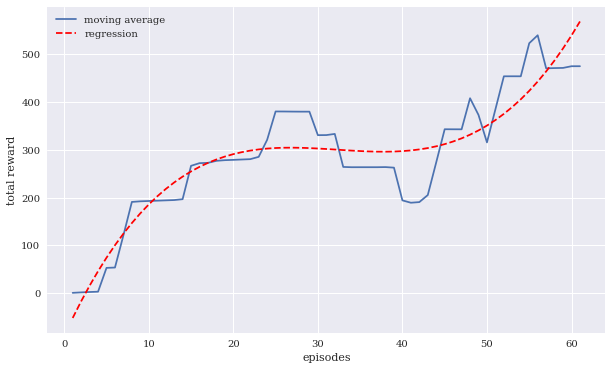

In [12]:
tradingbot.plot_treward(agent)
# plt.savefig('../../images/ch11/figure_rm_01.png');

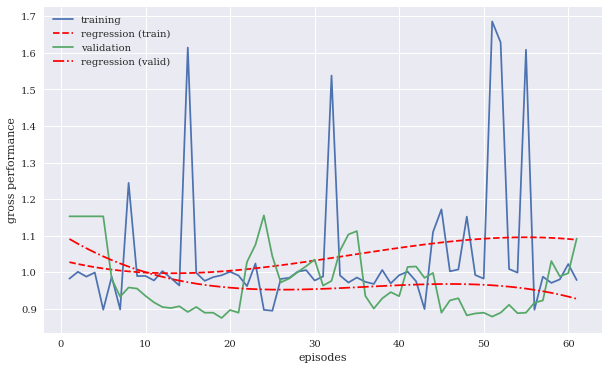

In [13]:
tradingbot.plot_performance(agent)
# plt.savefig('../../images/ch11/figure_rm_02.png');

In [14]:
def reshape(s):
    return np.reshape(s, [1, learn_env.lags,
                          learn_env.n_features])

In [15]:
def backtest(agent, env):
    env.min_accuracy = 0.0
    env.min_performance = 0.0
    done = False
    env.data['p'] = 0
    state = env.reset()
    while not done:
        action = np.argmax(
            agent.model.predict(reshape(state))[0, 0])
        position = 1 if action == 1 else -1
        env.data.loc[:, 'p'].iloc[env.bar] = position
        state, reward, done, info = env.step(action)
    env.data['s'] = env.data['p'] * env.data['r'] * learn_env.leverage

In [16]:
env = agent.learn_env

In [17]:
backtest(agent, env)

In [18]:
env.data['p'].iloc[env.lags:].value_counts()

 1    961
-1    786
Name: p, dtype: int64

In [19]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   0.7725
s   1.5155
dtype: float64

In [20]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

r   -0.2275
s    0.5155
dtype: float64

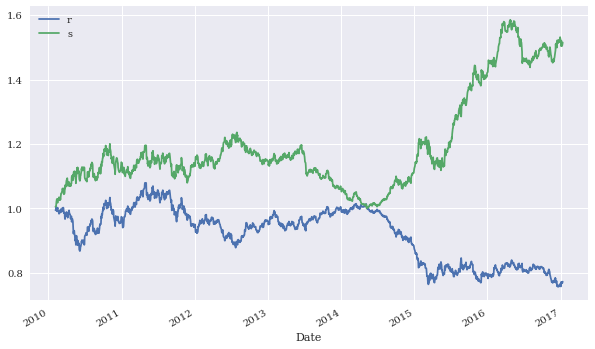

In [21]:
env.data[['r', 's']].iloc[env.lags:].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch11/figure_rm_03.png');

In [22]:
test_env = finance.Finance(symbol, features=learn_env.features,
                           window=learn_env.window,
                           lags=learn_env.lags,
                           leverage=learn_env.leverage,
                           min_performance=0.0, min_accuracy=0.0,
                           start=a + b + c, end=None,
                           mu=learn_env.mu, std=learn_env.std)

In [23]:
env = test_env

In [24]:
backtest(agent, env)

In [25]:
env.data['p'].iloc[env.lags:].value_counts()

-1    437
 1     56
Name: p, dtype: int64

In [26]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   0.9144
s   1.0992
dtype: float64

In [27]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

r   -0.0856
s    0.0992
dtype: float64

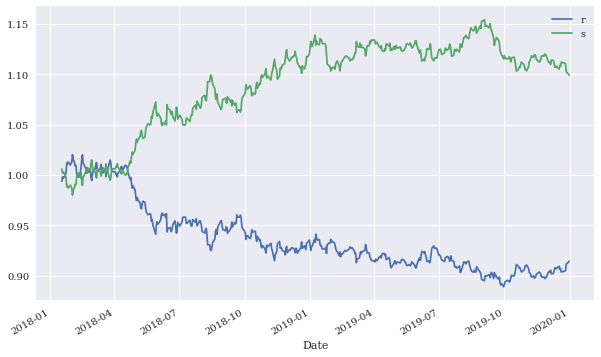

In [28]:
env.data[['r', 's']].iloc[env.lags:].cumsum(
            ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch11/figure_rm_04.png');

In [29]:
import backtesting as bt

In [30]:
bb = bt.BacktestingBase(env=agent.learn_env, model=agent.model,
                        amount=10000, ptc=0.0001, ftc=1.0,
                        verbose=True) 

In [31]:
bb.initial_amount

10000

In [32]:
bar = 100

In [33]:
bb.get_date_price(bar)

('2010-06-25', 1.2374)

In [34]:
bb.env.get_state(bar)

,EUR=,r,s,m,v
Date,,,,,
2010-06-22,-0.0242,-0.5622,-0.0916,-0.2022,1.5316
2010-06-23,0.0176,0.6940,-0.0939,-0.0915,1.5563
2010-06-24,0.0354,0.3034,-0.0865,0.6391,1.0890


In [35]:
bb.place_buy_order(bar, amount=5000)

2010-06-25 | buy 4040 units for 1.2374
2010-06-25 | current balance = 4999.40


In [36]:
bb.print_net_wealth(2 * bar)

2010-11-16 | net wealth = 10450.17


In [37]:
bb.place_sell_order(2 * bar, units=1000)

2010-11-16 | sell 1000 units for 1.3492
2010-11-16 | current balance = 6347.47


In [38]:
bb.close_out(3 * bar)

2011-04-11 | *** CLOSING OUT ***
2011-04-11 | sell 3040 units for 1.4434
2011-04-11 | current balance = 10733.97
2011-04-11 | net performance [%] = 7.3397
2011-04-11 | number of trades [#] = 3


In [39]:
class TBBacktester(bt.BacktestingBase):
    def _reshape(self, state):
        ''' Helper method to reshape state objects.
        '''
        return np.reshape(state, [1, self.env.lags, self.env.n_features])
    def backtest_strategy(self):
        ''' Event-based backtesting of the trading bot's performance.
        '''
        self.units = 0
        self.position = 0
        self.trades = 0
        self.current_balance = self.initial_amount
        self.net_wealths = list()
        for bar in range(self.env.lags, len(self.env.data)):
            date, price = self.get_date_price(bar)
            if self.trades == 0:
                print(50 * '=')
                print(f'{date} | *** START BACKTEST ***')
                self.print_balance(bar)
                print(50 * '=')
            state = self.env.get_state(bar)
            action = np.argmax(self.model.predict(
                        self._reshape(state.values))[0, 0])
            position = 1 if action == 1 else -1
            if self.position in [0, -1] and position == 1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING LONG ***')
                if self.position == -1:
                    self.place_buy_order(bar - 1, units=-self.units)
                self.place_buy_order(bar - 1,
                                     amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = 1
            elif self.position in [0, 1] and position == -1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING SHORT ***')
                if self.position == 1:
                    self.place_sell_order(bar - 1, units=self.units)
                self.place_sell_order(bar - 1,
                                      amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = -1
            self.net_wealths.append((date,
                                     self.calculate_net_wealth(price)))
        self.net_wealths = pd.DataFrame(self.net_wealths,
                                        columns=['date', 'net_wealth'])
        self.net_wealths.set_index('date', inplace=True)
        self.net_wealths.index = pd.DatetimeIndex(
                                        self.net_wealths.index)
        self.close_out(bar)

In [40]:
env = learn_env

In [41]:
tb = TBBacktester(env, agent.model, 10000,
                  0.0, 0, verbose=False)

In [42]:
tb.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 14601.85
2017-01-12 | net performance [%] = 46.0185
2017-01-12 | number of trades [#] = 828


In [43]:
tb_ = TBBacktester(env, agent.model, 10000,
                   0.00012, 0.0, verbose=False)

In [44]:
tb_.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 13222.08
2017-01-12 | net performance [%] = 32.2208
2017-01-12 | number of trades [#] = 828


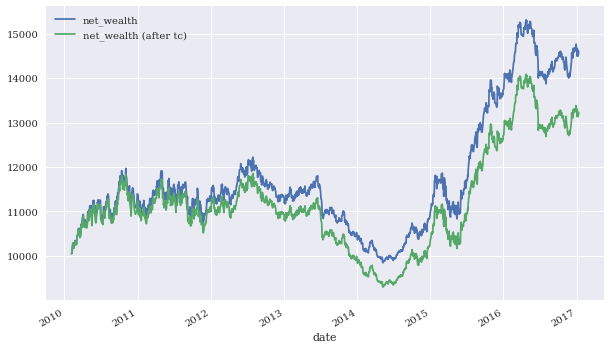

In [45]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);
# plt.savefig('../../images/ch11/figure_rm_05.png');

In [46]:
env = test_env

In [47]:
tb = TBBacktester(env, agent.model, 10000,
                  0.0, 0, verbose=False)

In [48]:
tb.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10936.79
2019-12-31 | net performance [%] = 9.3679
2019-12-31 | number of trades [#] = 186


In [49]:
tb_ = TBBacktester(env, agent.model, 10000,
                   0.00012, 0.0, verbose=False)

In [50]:
tb_.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10695.72
2019-12-31 | net performance [%] = 6.9572
2019-12-31 | number of trades [#] = 186


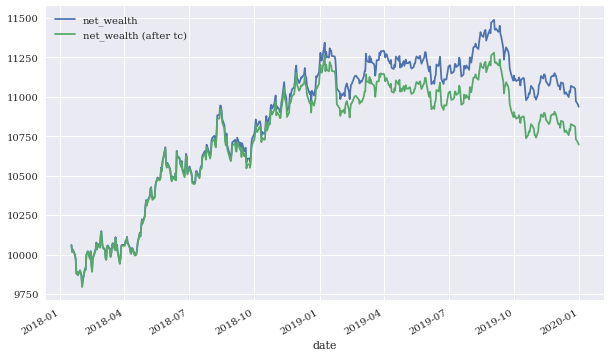

In [51]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);
# plt.savefig('../../images/ch11/figure_rm_06.png');

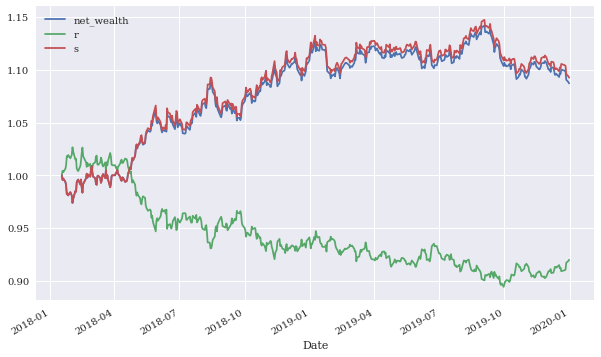

In [52]:
ax = (tb.net_wealths / tb.net_wealths.iloc[0]).plot(figsize=(10, 6))
tp = env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp)
(tp / tp.iloc[0]).plot(ax=ax);
# plt.savefig('../../images/ch11/figure_rm_07.png');

In [53]:
data = pd.DataFrame(learn_env.data[symbol])

In [54]:
data.head()

,EUR=
Date,
2010-02-02,1.3961
2010-02-03,1.3898
2010-02-04,1.3734
2010-02-05,1.3662
2010-02-08,1.3652


In [55]:
window = 14

In [56]:
data['min'] = data[symbol].rolling(window).min()

In [57]:
data['max'] = data[symbol].rolling(window).max()

In [58]:
data['mami'] = data['max'] - data['min']

In [59]:
data['mac'] = abs(data['max'] - data[symbol].shift(1))

In [60]:
data['mic'] = abs(data['min'] - data[symbol].shift(1))

In [61]:
data['atr'] = np.maximum(data['mami'], data['mac'])

In [62]:
data['atr'] = np.maximum(data['atr'], data['mic'])

In [63]:
data['atr%'] = data['atr'] / data[symbol]

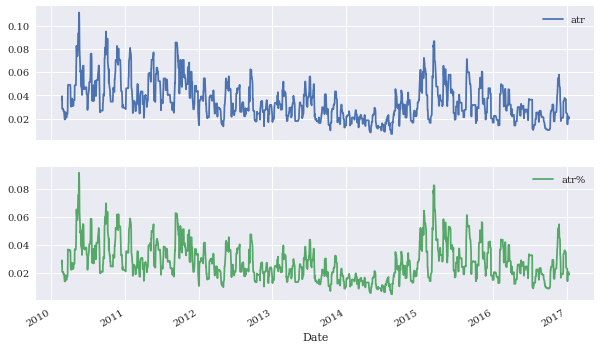

In [64]:
data[['atr', 'atr%']].plot(subplots=True, figsize=(10, 6));
# plt.savefig('../../images/ch11/figure_rm_08.png');

In [65]:
data[['atr', 'atr%']].tail()

,atr,atr%
Date,,
2017-01-06,0.0218,0.0207
2017-01-09,0.0218,0.0206
2017-01-10,0.0218,0.0207
2017-01-11,0.0199,0.0188
2017-01-12,0.0206,0.0194


In [66]:
leverage = 10

In [67]:
data[['atr', 'atr%']].tail() * leverage

,atr,atr%
Date,,
2017-01-06,0.2180,0.2070
2017-01-09,0.2180,0.2062
2017-01-10,0.2180,0.2066
2017-01-11,0.1990,0.1881
2017-01-12,0.2060,0.1942


In [68]:
data[['atr', 'atr%']].median() * leverage

atr    0.3180
atr%   0.2481
dtype: float64

In [69]:
import tbbacktesterrm as tbbrm

In [70]:
env = test_env

In [71]:
tb = tbbrm.TBBacktesterRM(env, agent.model, 10000,
                          0.0, 0, verbose=False)

In [72]:
tb.backtest_strategy(sl=None, tsl=None, tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10936.79
2019-12-31 | net performance [%] = 9.3679
2019-12-31 | number of trades [#] = 186


In [73]:
tb.backtest_strategy(sl=0.0175, tsl=None, tp=None,
                     wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0203) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10717.32
2019-12-31 | net performance [%] = 7.1732
2019-12-31 | number of trades [#] = 188


In [74]:
tb.backtest_strategy(sl=0.017, tsl=None, tp=None,
                     wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0170) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10753.52
2019-12-31 | net performance [%] = 7.5352
2019-12-31 | number of trades [#] = 188


In [75]:
tb.backtest_strategy(sl=None, tsl=0.015,
                     tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0152) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0169) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0164) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0191) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0166) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0194) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0172) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0181) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0153) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0160) ***
2019-12-31 | *** CLOSING OUT ***
2

In [76]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.015,
                     wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0155) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0155) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0204) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0240) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0168) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0156) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0183) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 11210.33
2019-12-31 | net performance [%] = 12.1033
2019-12-31 | number of trades [#] = 198


In [77]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.015,
                     wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10980.86
2019-12-31 | net performance [%] = 9.8086
2019-12-31 | number of trades [#] = 198


In [78]:
tb.backtest_strategy(sl=0.015, tsl=None,
                     tp=0.0185, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0203) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0202) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0213) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0240) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0171) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0188) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0153) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0154) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10552.00
2019-12-31 | net performance [%] = 5.5200
2019-12-31 | number of trades [#] = 201


In [79]:
tb.backtest_strategy(sl=None, tsl=0.02,
                     tp=0.02, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0235) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0202) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0250) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0227) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0240) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0216) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0241) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0206) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10346.38
2019-12-31 | net performance [%] = 3.4638
2019-12-31 | number of trades [#] = 198


<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>